# HOMEWORK 4

For this homework you are going to implement a lane line detector. Lane line detection is crucial for ADAS (Advanced Driver Assistance Systems) systems and, in particular, for LKA (Lane Keep Assist). You will use a [picture](https://en.wikipedia.org/wiki/Lane_departure_warning_system) from a front facing camera (mounted on the car) and will implement the following steps:
* Convert image to gray scale
* Compute edge map
* Apply Hough transform to obtain line parametrizations

In [4]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load and show the camera frame.

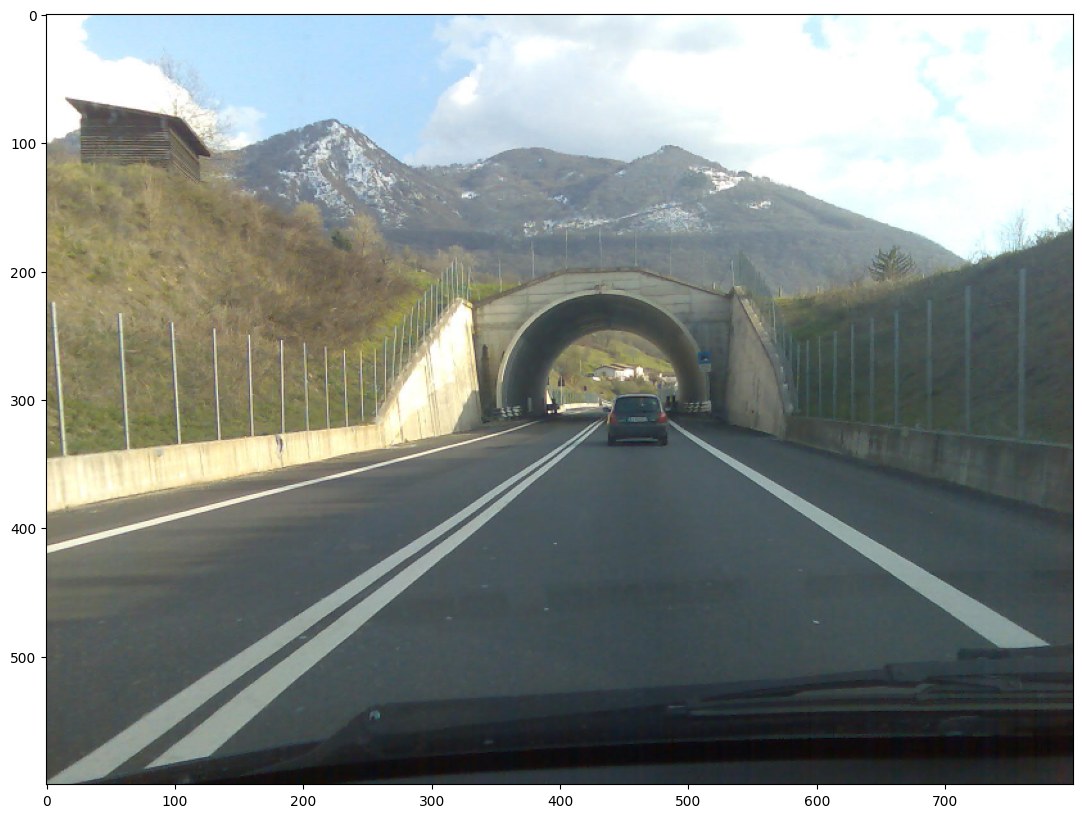

In [5]:
img = cv2.imread('../data/dashcam.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, None, fx=0.5, fy=0.5)
plt.imshow(img)

In [6]:
# Convert image to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [7]:
# Obtain edge map
# Hint: you can use Canny edge detector with th_low = 100, th_high = 150
edges = cv2.Canny(gray, 100, 150)

# We are only interseted in the road so we will remove everything above the horizon
edges[0:350] = 0

(<Axes: title={'center': 'Edge map'}>,
 Text(0.5, 1.0, 'Edge map'))

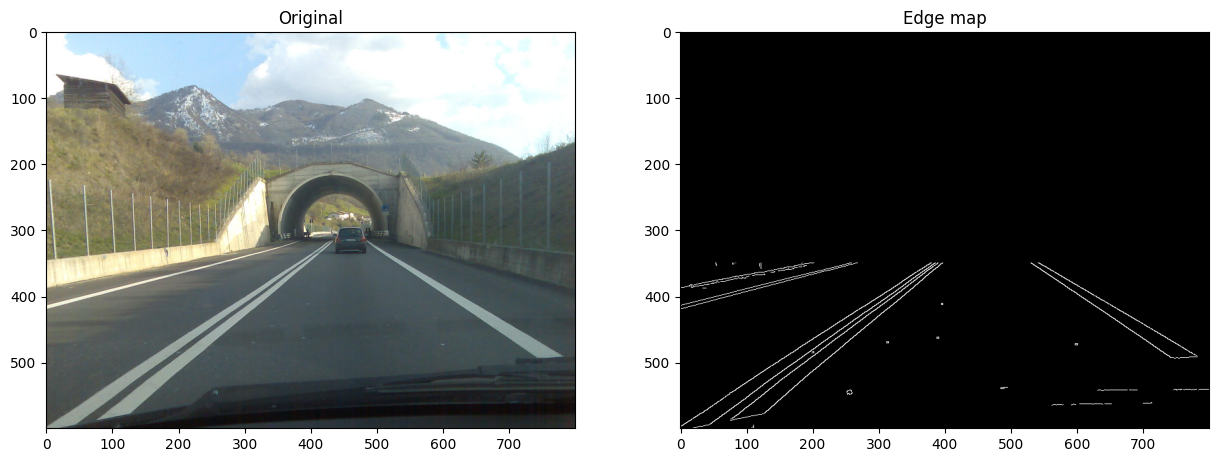

In [8]:
# Let's plot the images
plt.subplot(121), plt.imshow(img), plt.title('Original')
plt.subplot(122), plt.imshow(edges, cmap='gray'), plt.title('Edge map')

In [16]:
# Apply Hough transform to parametrize the lines
# Hint 1: Offset resolution of 2 pixels and slope resolution of 2 degrees work well in this case
# Hint 2: A suitable value for the accumulator threshold is 190
rho_res = 2              # pixels
theta_res = np.deg2rad(2)  # radians
acc_threshold = 190

lines = cv2.HoughLines(edges, rho_res, theta_res, acc_threshold)

# safety
if lines is None:
    lines = np.empty((0, 1, 2), dtype=np.float32)

lines.shape, lines[:3]

((10, 1, 2),
 array([[[522.        ,   0.87266463]],
 
        [[506.        ,   0.94247776]],
 
        [[510.        ,   0.9075712 ]]], dtype=float32))

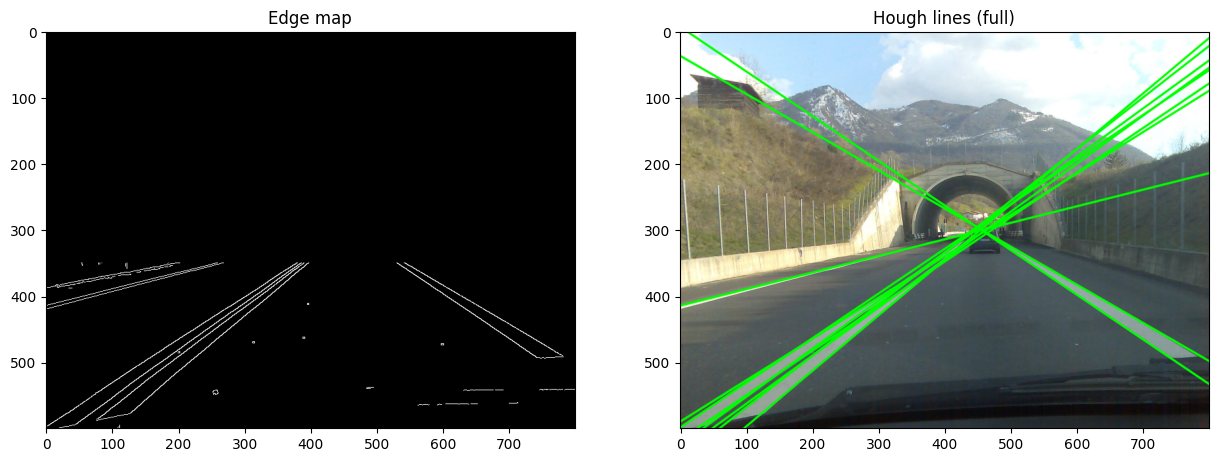

In [17]:
result = np.copy(img)

for line in lines:
    rho, theta = line[0]

    a = np.cos(theta)
    b = np.sin(theta)

    x0 = a * rho
    y0 = b * rho

    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))

    cv2.line(result, pt1, pt2, (0, 255, 0), 2, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result), plt.title('Hough lines (full)')
plt.show()

The edge map looks good but the Hough lines are too noisy. Let's clean the Hough lines first by removing all lines that we know cannot represent a lane line. In other words, all lines that are approximately horizontal shall be removed. Remember that horizontal lines correspond to theta = 90 degrees.

In [18]:
filtered_lines = []

horiz = np.pi / 2
tol = np.deg2rad(20)

for line in lines:
    rho, theta = line[0]

    # remove near-horizontal: keep everything OUTSIDE [90-20, 90+20]
    if not (horiz - tol <= theta <= horiz + tol):
        filtered_lines.append([rho, theta])

filtered_lines = np.array(filtered_lines, dtype=np.float32)  # (M,2)

filtered_lines.shape, filtered_lines[:5]

((9, 2),
 array([[522.        ,   0.87266463],
        [506.        ,   0.94247776],
        [510.        ,   0.9075712 ],
        [496.        ,   0.9773844 ],
        [ -6.        ,   2.1642082 ]], dtype=float32))

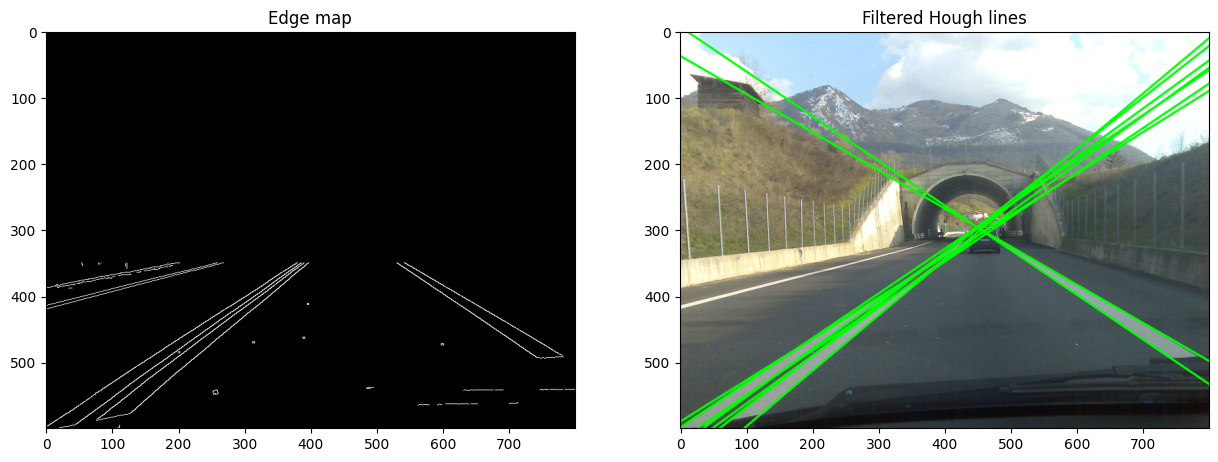

In [19]:
# Let's plot the resulting filtered lines
result = np.copy(img)

for rho, theta in filtered_lines:
    a = np.cos(theta)
    b = np.sin(theta)

    x0 = a * rho
    y0 = b * rho

    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))

    cv2.line(result, pt1, pt2, (0, 255, 0), 2, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result), plt.title('Filtered Hough lines')
plt.show()

The result is now much better, but still we see some very similar lines. How can we get rid of them?
* Let's apply k-means clustering. It will find the clusters of the 6 we see in the picture lines and use the averages.

In [20]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

from sklearn.cluster import KMeans

# safety: якщо мало ліній — не кластеризуємо
if len(filtered_lines) < 6:
    centers = filtered_lines.copy()
else:
    kmeans = KMeans(n_clusters=6, random_state=0, n_init=10).fit(filtered_lines)
    centers = kmeans.cluster_centers_.astype(np.float32)

centers

array([[ -6.        ,   2.1642082 ],
       [512.        ,   0.94247776],
       [ 32.        ,   2.0943952 ],
       [498.        ,   0.99483764],
       [506.        ,   0.94247776],
       [522.        ,   0.87266463]], dtype=float32)

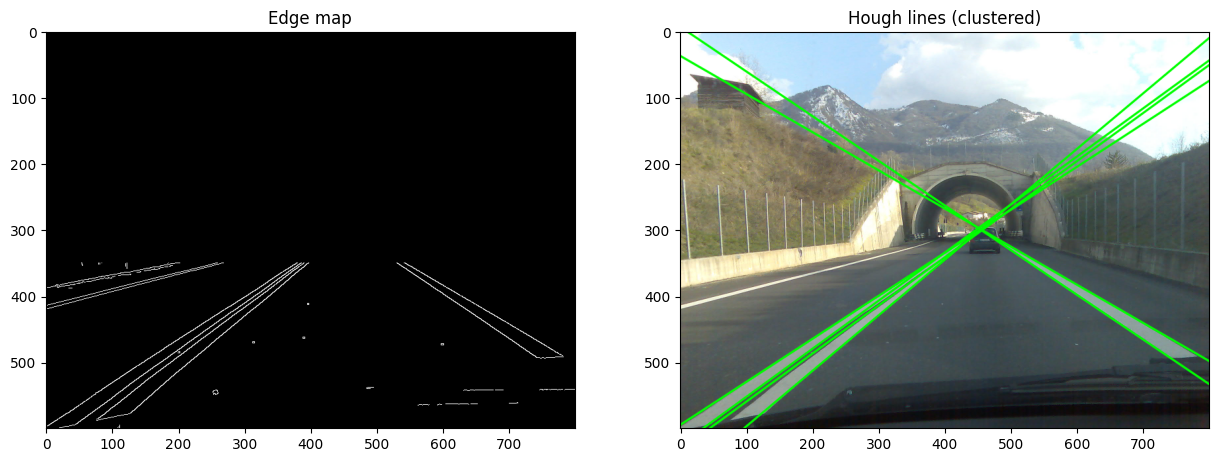

In [22]:
result = np.copy(img)

for rho, theta in centers:
    a = np.cos(theta)
    b = np.sin(theta)

    x0 = a * rho
    y0 = b * rho

    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))

    cv2.line(result, pt1, pt2, (0, 255, 0), 2, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result), plt.title('Hough lines (clustered, full)')
plt.show()

### Questions
* Do you see anything strange in the final result?
Yes - some detected lines are still slightly misaligned with the actual lane edges and may extend beyond the road region. Also, a few lines can be redundant or shifted due to clustering on noisy detections.
* Do you think the Hough transform resolution is important for obtaining a good result? Why?
Yes. The rho and theta resolution determines how precisely lines are represented. Too coarse resolution merges different lines; too fine resolution increases noise and duplicate detections. Proper resolution balances accuracy and stability.
* Do you think the Hough transform accumulator threshold is important for obtaining a good result? Why?
Yes. The threshold controls how strong a line must be to be accepted. Too low - many false/noisy lines. Too high - missing true lane lines. A suitable threshold keeps only meaningful, well-supported lines.